# CNN and LSTM for deceptive opinion spam detection on Keras
In this notebook, we are going to build CNN for a text classification task.

The used corpus consists of truthful and deceptive hotel reviews of 20 Chicago hotels. The corpus also contain other information information on whether the review was deceptive, what hotel it was for, whether it was a positive or negative review, the source of the review and the text of the review. The data is open in [Kaggle](https://www.kaggle.com/rtatman/deceptive-opinion-spam-corpus).  

## Agenda

1. EDA for Text Corpus
2. Data Preprocessing
3. Neural Network for Text Classification

    3.1 Word-level CNN
    
    3.2 Word-level RNN

### Load Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
from sklearn.model_selection import train_test_split

## 1. EDA for Text Corpus

- Check Class Balance
- Word Cloud 
- Review Length

In [ ]:
basefn = "..//data//"
df_corpus = pd.read_csv(basefn + "deceptive_opinion.csv")

In [ ]:
df_corpus.head(2)

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...


In [ ]:
df_corpus['label'] = 1
df_corpus.loc[df_corpus['deceptive']=='truthful', 'label'] = 0

In [ ]:
df_corpus.head()

,deceptive,hotel,polarity,source,text,label
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,0
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,0
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,0
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,0
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...,0


### Class Balance

In [ ]:
df_corpus['deceptive'].value_counts(normalize=True)

truthful     0.5
deceptive    0.5
Name: deceptive, dtype: float64

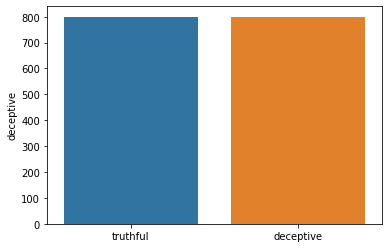

In [ ]:
sns.barplot(x=['truthful', 'deceptive'], y=df_corpus.deceptive.value_counts())

### Word Cloud for Each Class

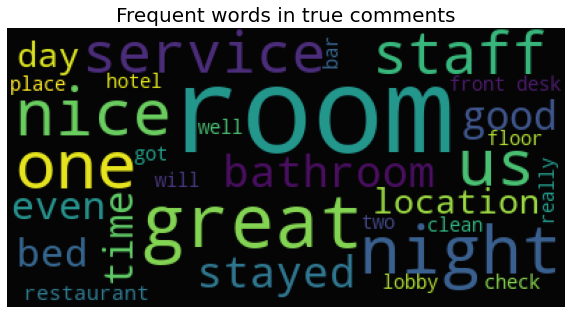

In [ ]:
true_comments = df_corpus[df_corpus.label == 0]['text'].values
wc = WordCloud(background_color="black", max_words=30, stopwords=STOPWORDS.update(['Chicago', 'hotel', 'stay']))
wc.generate(" ".join(true_comments))

plt.figure(figsize=(10,8))
plt.axis("off")
plt.title("Frequent words in true comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

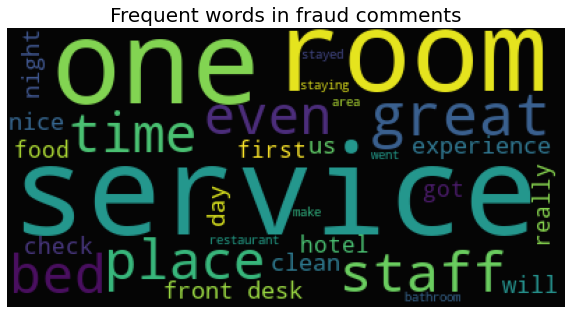

In [ ]:
fraud_comments = df_corpus[df_corpus.label == 1]['text'].values
wc = WordCloud(background_color="black", max_words=30, stopwords=STOPWORDS.update(['Chicago', 'hotel', 'room']))
wc.generate(" ".join(fraud_comments))

plt.figure(figsize=(10,8))
plt.axis("off")
plt.title("Frequent words in fraud comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

### Text Size per each class

In [ ]:
def text_size(df):
    """
    compute the text size, i.e., number of words 
    """
    sizes = []
    for text in df['text']:
        len_ = len(text.split())
        sizes.append(len_)
    return np.array(sizes)

fraud_df = df_corpus[df_corpus.label == 1].copy()
true_df  = df_corpus[df_corpus.label == 0].copy()
fraud_size = text_size(fraud_df)
true_size = text_size(true_df)
fraud_df['len'] = fraud_size
true_df['len'] = true_size
concat = pd.concat([fraud_df, true_df])
concat['is_fraud'] = concat['label'] 

In [ ]:
fig = px.box(concat, y='len', x='is_fraud')
fig.show()

## 2. Text Preprocessing

Clean the reviews by removing html tag, punctuations and alpha numeric words. And all words are converted to lower case.

In [ ]:
import re
from bs4 import BeautifulSoup

In [ ]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    # 2. Only keep letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    return( " ".join(words)) 

In [ ]:
# Get the number of reviews based on the dataframe column size
num_reviews = df_corpus["text"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range(0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( df_corpus["text"][i] ) )

In [ ]:
# check the review sentence
clean_train_reviews[0]

'we stayed for a one night getaway with family on a thursday triple aaa rate of was a steal th floor room complete with in plasma tv bose stereo voss and evian water and gorgeous bathroom no tub but was fine for us concierge was very helpful you cannot beat this location only flaw was breakfast was pricey and service was very very slow hours for four kids and four adults on a friday morning even though there were only two other tables in the restaurant food was very good so it was worth the wait i would return in a heartbeat a gem in chicago'

## 3. Word-level CNN and RNN

In [ ]:
## Import Packages
## Keras is now fully intregrated into Tensorflow. Try to import keras from TF
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.layers import Input, Dense, Embedding, Activation, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, SimpleRNN,Bidirectional

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
labels = df_corpus["label"].tolist()

In [ ]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(clean_train_reviews, labels, test_size=0.25, random_state=123)

In [ ]:
vocab_size =  8000
tk = Tokenizer(num_words=vocab_size)  ## here, we are set the max number of words to keep. The most common 7999 words will be kept
tk.fit_on_texts(train_reviews)

In [ ]:
# Convert string to index
train_sequences = tk.texts_to_sequences(train_reviews)
test_texts = tk.texts_to_sequences(test_reviews)

- Since reviews have different lengths, we need to make all the reviews having the same length  
- The unified length is set to be the max length of all documents in training corpus

In [ ]:
sequence_length = max([len(ele) for ele in train_sequences]) 
# Padding
train_data = pad_sequences(train_sequences, maxlen=sequence_length, padding='post')
test_data = pad_sequences(test_texts, maxlen=sequence_length, padding='post')

In [ ]:
print("the input sequence's length is fixed to be {}".format(sequence_length))

the input sequence's length is fixed to be 797


In [ ]:
# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')
train_classes = np.array(train_labels, dtype='int')
test_classes = np.array(test_labels, dtype='int')

#####   Model API
Keras provides a Model class that you can use to create a model from your created layers. Compared to the other API **sequentia**, [model API](https://machinelearningmastery.com/keras-functional-api-deep-learning/) is more flexible.


### 3.1   CNN Framework

1. This is a CNN network for sentence classification.

2. Filters Sizes are 2, 3, 4.

3. In our following implementation, filters sizes are 2,3,4. Each filter size has 30 filters. The embeddings size is 30. 


![alt text](https://github.com/rz0718/colab_imgs/blob/main/imgs/cnn.png?raw=true)

In [ ]:
embedding_dim = 20    # The size of embeddings is 20
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)
# Embedding Layer
# Here, we randomly initalize the input word embeddings
# The embeddings would be updated as the following layers' parameters
z_cnn = Embedding(vocab_size, embedding_dim, input_length=sequence_length, name="embedding")(model_input)

##### Using pre-trained word embeddings

Load the embedding matrix into the Embedding layer.

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [ ]:
# Convolutional Layer 
conv_blocks = []
#capture two-grams, 3-grams and 4 grams
filter_sizes = [2,3,4]
#for each filter, the number of filters
num_filters = 30
#loop over the different filter sizes
for sz in filter_sizes:
    # sz is the window size
    conv = Conv1D(filters=num_filters,
                  kernel_size=sz,
                  padding="valid",
                  activation="relu",
                  strides=1)(z_cnn)
    # Pooling Layer
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
# Fully-connected Layer
hiddenz = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

In [ ]:
# It is binary classifcation problem. We can use sigmoid layer.
# If it is multi-class classifcaiton problem, we can use softmax layer 
model_output = Dense(1, activation="sigmoid")(hiddenz)
cnn_model = Model(model_input, model_output)
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
print(cnn_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 797)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 797, 20)      160000      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 796, 30)      1230        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 795, 30)      1830        ['embedding[0][0]']              
                                                                                              

In [ ]:
# Training
cnn_model.fit(train_data, train_classes,
          validation_data=(test_data, test_classes),
          batch_size=32,
          epochs=10,
          verbose=2)

Epoch 1/10
38/38 - 5s - loss: 0.6913 - accuracy: 0.5592 - val_loss: 0.6863 - val_accuracy: 0.5575 - 5s/epoch - 121ms/step
Epoch 2/10
38/38 - 5s - loss: 0.6670 - accuracy: 0.6317 - val_loss: 0.6708 - val_accuracy: 0.7775 - 5s/epoch - 126ms/step
Epoch 3/10
38/38 - 5s - loss: 0.6316 - accuracy: 0.8992 - val_loss: 0.6372 - val_accuracy: 0.7275 - 5s/epoch - 142ms/step
Epoch 4/10
38/38 - 5s - loss: 0.5650 - accuracy: 0.8683 - val_loss: 0.5730 - val_accuracy: 0.7475 - 5s/epoch - 130ms/step
Epoch 5/10
38/38 - 3s - loss: 0.4680 - accuracy: 0.8533 - val_loss: 0.5120 - val_accuracy: 0.7750 - 3s/epoch - 76ms/step
Epoch 6/10
38/38 - 3s - loss: 0.3781 - accuracy: 0.8867 - val_loss: 0.4579 - val_accuracy: 0.8025 - 3s/epoch - 76ms/step
Epoch 7/10
38/38 - 3s - loss: 0.2916 - accuracy: 0.9242 - val_loss: 0.4186 - val_accuracy: 0.8075 - 3s/epoch - 78ms/step
Epoch 8/10
38/38 - 3s - loss: 0.2212 - accuracy: 0.9492 - val_loss: 0.3917 - val_accuracy: 0.8325 - 3s/epoch - 79ms/step
Epoch 9/10
38/38 - 3s - loss

1. The training acc. can be over 90% and the val. acc. is around 84%. CNN or deep learning that are too complext are able to memorize the data. Therefore, given a small dataset, they may overfit since thay can achieve lower cost by directly memorizing instead of generalization.

2. In practice, the number of positive class and negative class will not be equal or balanced especially in the fraud detection domain. How to address class imbalanced issue? You may find some useful tips with codes examples [here](https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data) 

### 3.2   RNN Framework

In [ ]:
embedding_dim = 20    # The size of embeddings is 20
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)
# Embedding Layer
# Here, we randomly initalize the input word embeddings
# The embeddings would be updated as the following layers' parameters
z_RNN = Embedding(vocab_size, embedding_dim, input_length=sequence_length, name="embedding")(model_input)

In [ ]:
hidden_output = Bidirectional(SimpleRNN(20))(z_RNN)
model_output = Dense(1, activation="sigmoid")(hidden_output)

In [ ]:
rnn_model = Model(model_input, model_output)
rnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
print(rnn_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 797)]             0         
                                                                 
 embedding (Embedding)       (None, 797, 20)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               1640      
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 161,681
Trainable params: 161,681
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Training
rnn_model.fit(train_data, train_classes,
          validation_data=(test_data, test_classes),
          batch_size=32,
          epochs=10,
          verbose=2)

Epoch 1/10
38/38 - 16s - loss: 0.6911 - accuracy: 0.5308 - val_loss: 0.6775 - val_accuracy: 0.6000 - 16s/epoch - 412ms/step
Epoch 2/10
38/38 - 13s - loss: 0.6031 - accuracy: 0.8058 - val_loss: 0.6540 - val_accuracy: 0.6300 - 13s/epoch - 354ms/step
Epoch 3/10
38/38 - 15s - loss: 0.4861 - accuracy: 0.9142 - val_loss: 0.6341 - val_accuracy: 0.6425 - 15s/epoch - 399ms/step
Epoch 4/10
38/38 - 14s - loss: 0.3559 - accuracy: 0.9517 - val_loss: 0.6317 - val_accuracy: 0.6450 - 14s/epoch - 361ms/step
Epoch 5/10
38/38 - 14s - loss: 0.2403 - accuracy: 0.9917 - val_loss: 0.6348 - val_accuracy: 0.6225 - 14s/epoch - 356ms/step
Epoch 6/10
38/38 - 13s - loss: 0.1424 - accuracy: 0.9975 - val_loss: 0.6765 - val_accuracy: 0.6225 - 13s/epoch - 355ms/step
Epoch 7/10
38/38 - 13s - loss: 0.0914 - accuracy: 1.0000 - val_loss: 0.7384 - val_accuracy: 0.5750 - 13s/epoch - 347ms/step
Epoch 8/10
38/38 - 13s - loss: 0.0759 - accuracy: 1.0000 - val_loss: 0.7292 - val_accuracy: 0.6175 - 13s/epoch - 355ms/step
Epoch 9/

Compare the training speeds of CNN and RNN. Under the roughly same number of parameters, CNN is much faster than RNN. It can be explained by the fact that **RNN is not suitable for parallel computing**. This limitation of RNN and its variants: LSTM and GRU hinders their applications. 